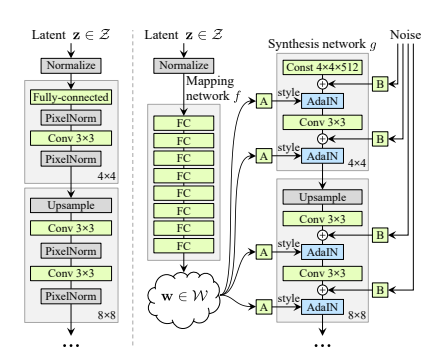

In [ ]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [ ]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.ImageFolder(
    root="data",      # родительская папка
    transform=transform
)


In [ ]:
loader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)


In [ ]:
imgs, _ = next(iter(loader))
print(imgs.shape)  # torch.Size([16, 3, 256, 256])


In [ ]:
"""class AdaIn(nn.Module):
  def __init__(self,x,y):
    super(AdaIn, self).__init__()
    self.delt = torch.std(x)
    self.u = torch.mean(x)
    self.y_s = y
    self.y_b = y
  def forward(self,x):
    out = (self.y_s*((x-self.u)/self.delt))+self.y_b
    print(out)
    return out"""

In [ ]:
import torch.nn as nn
import numpy as np
import torch

class AdaIn(nn.Module):
    def __init__(self, channels, w_dim=None):
        super(AdaIn, self).__init__()
        self.channels = channels

        # Если w_dim не указан, создаем обучаемые параметры
        if w_dim is None:
            self.y_s = nn.Parameter(torch.ones(1, channels, 1, 1))
            self.y_b = nn.Parameter(torch.zeros(1, channels, 1, 1))
            self.learnable = True
        else:
            # Если используется стиль извне (из вектора w)
            self.style_scale = nn.Linear(w_dim, channels)
            self.style_bias = nn.Linear(w_dim, channels)
            self.learnable = False

    def forward(self, x, w=None):
        # x: [batch, channels, height, width]
        batch_size, channels, height, width = x.shape

        # Вычисляем статистики для каждого экземпляра и каждого канала
        x_reshaped = x.view(batch_size, channels, -1)  # [batch, channels, height*width]

        u = x_reshaped.mean(dim=2, keepdim=True)  # [batch, channels, 1]
        delt = x_reshaped.std(dim=2, keepdim=True) + 1e-8  # [batch, channels, 1]

        # Нормализуем
        x_normalized = (x_reshaped - u) / delt
        x_normalized = x_normalized.view(batch_size, channels, height, width)

        # Применяем параметры стиля
        if self.learnable:
            # Используем обучаемые параметры
            out = x_normalized * self.y_s + self.y_b
        else:
            # Используем стиль из вектора w
            scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)  # [batch, channels, 1, 1]
            bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)    # [batch, channels, 1, 1]
            out = x_normalized * scale + bias

        return out

class mapnet(nn.Module):
  def __init__(self):
    super(mapnet, self).__init__()
    self.layr = nn.Linear
  def forward(self,z):
    z = torch.mean(z, dim=[-2, 3])
    l1 = self.layr(16,2)
    l1 = l1(z.T)

    nn.ReLU(l1)
    print(l1.shape)
    l2 = self.layr(2,4)
    l2 = l2(l1)
    nn.ReLU(l2)
    l3 = self.layr(4,16)
    l3 = l3(l2)
    nn.ReLU(l3)
    l4 = self.layr(16,32)
    l4 = l4(l3)
    nn.ReLU(l4)
    l5 = self.layr(32,64)
    l5 = l5(l4)
    print(l5.shape)
    nn.ReLU(l5)
    l6 = self.layr(64,128)
    l6 = l6(l5)
    nn.ReLU(l6)
    l7 = self.layr(128,256)
    l7 = l7(l6)
    nn.ReLU(l7)
    l8 = self.layr(256,512)
    l8 = l8(l7)
    nn.ReLU(l8)
    print(l8.shape)
    return l8

class generator(nn.Module):
  def __init__(self):
    super(generator, self).__init__()
    self.conv = nn.Conv2d
    self.noise = torch.randn
    self.adain = AdaIn(channels=64, w_dim=512)
    self.up = nn.Upsample(2,mode='bilinear')
    self.mapnet = mapnet()
  def forward(self,x):
    w1 = self.mapnet(x)
    print(w1.shape)
    x = x + torch.randn(16,2,256,256)
    print(1252)
    x = self.adain(x,w1)
    print(x.shape)
    x = self.up(x)
    x = x + self.noise
    w2 = self.mapnet(x)
    x = self.adain(x,w2)
    return x

class discriminator(nn.Module):
  def __init__(self):
    self.conv = nn.Conv2d()
    self.down = nn.MaxPool2d()
    self.dense = nn.Linear()
  def forward(self,g):
    x = self.conv(g)
    x = self.down(x)
    x = self.dense(x,1)
    return x


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale = nn.Linear(w_dim, channels)
        self.style_bias = nn.Linear(w_dim, channels)

    def forward(self, x, w):
        # Normalize
        x = self.instance_norm(x)

        # Get style parameters
        scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)  # [batch, channels, 1, 1]
        bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)    # [batch, channels, 1, 1]

        # Apply style
        x = x * scale + bias
        return x

class MappingNetwork(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, num_layers=8):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.extend([
                nn.Linear(z_dim if i == 0 else w_dim, w_dim),
                nn.LeakyReLU(0.2)
            ])
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        # Normalize latent vector
        z = F.normalize(z, p=2, dim=1)
        return self.net(z)

class NoiseInjection(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        batch, _, height, width = x.shape
        noise = torch.randn(batch, 1, height, width, device=x.device)
        return x + self.weight * noise

class StyleGANGeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.adain2 = AdaIN(out_channels, w_dim)
        self.noise1 = NoiseInjection(out_channels)
        self.noise2 = NoiseInjection(out_channels)
        self.activation = nn.LeakyReLU(0.2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')

    def forward(self, x, w):
        # Upsample if needed
        x = self.upsample(x)

        # First convolution + ADAIN + noise
        x = self.conv1(x)
        x = self.adain1(x, w)
        x = self.noise1(x)
        x = self.activation(x)

        # Second convolution + ADAIN + noise
        x = self.conv2(x)
        x = self.adain2(x, w)
        x = self.noise2(x)
        x = self.activation(x)

        return x

class StyleGANGenerator(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, in_channels=512, out_channels=3, resolution=256):
        super().__init__()
        self.z_dim = z_dim
        self.w_dim = w_dim

        # Mapping network
        self.mapping = MappingNetwork(z_dim, w_dim)

        # Starting constant
        self.constant = nn.Parameter(torch.randn(1, in_channels, 4, 4))

        # Generator blocks
        self.blocks = nn.ModuleList()

        # Calculate number of blocks based on resolution
        log_res = int(torch.log2(torch.tensor(resolution)))
        channels = in_channels

        for i in range(3, log_res + 1):  # from 4x4 to target resolution
            if i > 3:
                self.blocks.append(StyleGANGeneratorBlock(channels, channels // 2, w_dim))
                channels = channels // 2
            else:
                self.blocks.append(StyleGANGeneratorBlock(in_channels, channels, w_dim))

        # To RGB
        self.to_rgb = nn.Conv2d(channels, out_channels, 1, 1, 0)

    def forward(self, z):
        # Map latent to style
        w = self.mapping(z)

        # Start from constant
        batch_size = z.shape[0]
        x = self.constant.repeat(batch_size, 1, 1, 1)

        # Apply generator blocks
        for block in self.blocks:
            x = block(x, w)

        # Convert to RGB
        x = self.to_rgb(x)
        x = torch.tanh(x)  # Normalize to [-1, 1]

        return x

class StyleGANDiscriminatorBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.downsample = nn.AvgPool2d(2)
        self.activation = nn.LeakyReLU(0.2)

        # Residual connection
        self.residual = nn.Conv2d(in_channels, out_channels, 1, 1, 0)

    def forward(self, x):
        residual = self.residual(x)
        residual = self.downsample(residual)

        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.downsample(x)

        return x + residual

class StyleGANDiscriminator(nn.Module):
    def __init__(self, in_channels=3, resolution=256):
        super().__init__()

        # Initial from RGB
        self.from_rgb = nn.Conv2d(in_channels, 64, 1, 1, 0)

        # Discriminator blocks
        self.blocks = nn.ModuleList()

        # Calculate number of blocks based on resolution
        log_res = int(torch.log2(torch.tensor(resolution)))
        channels = 64

        for i in range(log_res, 2, -1):  # from target resolution to 4x4
            if i == log_res:
                self.blocks.append(StyleGANDiscriminatorBlock(64, 128))
                channels = 128
            else:
                self.blocks.append(StyleGANDiscriminatorBlock(channels, channels * 2))
                channels = channels * 2

        # Final layers
        self.final_conv = nn.Conv2d(channels, channels, 4, 1, 0)
        self.final_linear = nn.Linear(channels, 1)

    def forward(self, x):
        # From RGB
        x = self.from_rgb(x)

        # Apply discriminator blocks
        for block in self.blocks:
            x = block(x)

        # Final processing
        x = self.final_conv(x)
        x = x.view(x.shape[0], -1)
        x = self.final_linear(x)

        return x

# Пример использования
if __name__ == "__main__":
    # Generator
    gen = StyleGANGenerator(resolution=256)
    z = torch.randn(16, 512)  # latent vector
    fake_images = gen(z)
    print(f"Generated images shape: {fake_images.shape}")

    # Discriminator
    disc = StyleGANDiscriminator(resolution=256)
    real_score = disc(fake_images)
    print(f"Discriminator output shape: {real_score.shape}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x128 and 512x512)

In [1]:
# Создание моделей
generator = StyleGANGenerator(resolution=256)
discriminator = StyleGANDiscriminator(resolution=256)

# Генерация изображений
z = torch.randn(8, 512)
fake_images = generator(z)

# Оценка дискриминатором
scores = discriminator(fake_images)

NameError: name 'StyleGANGenerator' is not defined

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torchvision.utils as vutils
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch.nn.functional as F

# Конфигурация
config = {
    'z_dim': 512,
    'w_dim': 512,
    'batch_size': 4,  # Уменьшил для стабильности
    'image_size': 128,  # Уменьшил разрешение для начала
    'channels': 3,
    'lr_g': 0.001,
    'lr_d': 0.001,
    'epochs': 50,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'data_path': '/path/to/your/faces/dataset',
    'save_dir': './stylegan_results'
}

# Создание директории для сохранения результатов
os.makedirs(config['save_dir'], exist_ok=True)

class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.instance_norm = nn.InstanceNorm2d(channels, affine=False)
        self.style_scale = nn.Linear(w_dim, channels)
        self.style_bias = nn.Linear(w_dim, channels)

    def forward(self, x, w):
        x = self.instance_norm(x)
        scale = self.style_scale(w).unsqueeze(2).unsqueeze(3)
        bias = self.style_bias(w).unsqueeze(2).unsqueeze(3)
        return x * scale + bias

class MappingNetwork(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, num_layers=4):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layers.extend([
                nn.Linear(z_dim if i == 0 else w_dim, w_dim),
                nn.LeakyReLU(0.2)
            ])
        self.net = nn.Sequential(*layers)

    def forward(self, z):
        z = F.normalize(z, p=2, dim=1)
        return self.net(z)

class NoiseInjection(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros(1, channels, 1, 1))

    def forward(self, x):
        batch, _, height, width = x.shape
        noise = torch.randn(batch, 1, height, width, device=x.device)
        return x + self.weight * noise

# Переписываем блок генератора чтобы правильно передавать w
class StyleGANGeneratorBlock(nn.Module):
    def __init__(self, in_channels, out_channels, w_dim):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.adain1 = AdaIN(out_channels, w_dim)
        self.noise1 = NoiseInjection(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.adain2 = AdaIN(out_channels, w_dim)
        self.noise2 = NoiseInjection(out_channels)
        self.activation = nn.LeakyReLU(0.2)

        # Shortcut connection для изменения количества каналов
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.Conv2d(in_channels, out_channels, 1)
        )

    def forward(self, x, w):
        # Residual connection
        residual = self.shortcut(x)

        # Основной путь
        x = self.upsample(x)
        x = self.conv1(x)
        x = self.adain1(x, w)  # Передаем w
        x = self.noise1(x)
        x = self.activation(x)

        x = self.conv2(x)
        x = self.adain2(x, w)  # Передаем w
        x = self.noise2(x)
        x = self.activation(x)

        return x + residual

class StyleGANGenerator(nn.Module):
    def __init__(self, z_dim=512, w_dim=512, resolution=128):
        super().__init__()
        self.z_dim = z_dim
        self.w_dim = w_dim
        self.mapping = MappingNetwork(z_dim, w_dim)

        # Начальный постоянный тензор
        self.initial_constant = nn.Parameter(torch.randn(1, 512, 4, 4))

        # Определяем блоки в зависимости от разрешения
        self.blocks = nn.ModuleList()
        self.to_rgb_layers = nn.ModuleList()

        # Конфигурация блоков: (in_channels, out_channels)
        if resolution == 128:
            block_config = [
                (512, 512),  # 4x4 -> 8x8
                (512, 512),  # 8x8 -> 16x16
                (512, 256),  # 16x16 -> 32x32
                (256, 128),  # 32x32 -> 64x64
                (128, 64),   # 64x64 -> 128x128
            ]
        elif resolution == 256:
            block_config = [
                (512, 512),  # 4x4 -> 8x8
                (512, 512),  # 8x8 -> 16x16
                (512, 512),  # 16x16 -> 32x32
                (512, 256),  # 32x32 -> 64x64
                (256, 128),  # 64x64 -> 128x128
                (128, 64),   # 128x128 -> 256x256
            ]

        # Создаем блоки
        for in_ch, out_ch in block_config:
            self.blocks.append(StyleGANGeneratorBlock(in_ch, out_ch, w_dim))
            self.to_rgb_layers.append(nn.Conv2d(out_ch, 3, 1))

    def forward(self, z):
        # Генерируем вектор стиля
        w = self.mapping(z)
        batch_size = z.size(0)

        # Начинаем с постоянного тензора
        x = self.initial_constant.repeat(batch_size, 1, 1, 1)

        # Применяем блоки генератора
        for i, block in enumerate(self.blocks):
            x = block(x, w)  # Передаем w в каждый блок

        # Final to RGB
        x = self.to_rgb_layers[-1](x)
        return torch.tanh(x)

class StyleGANDiscriminator(nn.Module):
    def __init__(self, resolution=128):
        super().__init__()

        self.blocks = nn.ModuleList()

        # Конфигурация в зависимости от разрешения
        if resolution == 128:
            block_config = [
                (3, 64),    # 128x128 -> 64x64
                (64, 128),  # 64x64 -> 32x32
                (128, 256), # 32x32 -> 16x16
                (256, 512), # 16x16 -> 8x8
                (512, 512), # 8x8 -> 4x4
            ]
        elif resolution == 256:
            block_config = [
                (3, 64),    # 256x256 -> 128x128
                (64, 128),  # 128x128 -> 64x64
                (128, 256), # 64x64 -> 32x32
                (256, 512), # 32x32 -> 16x16
                (512, 512), # 16x16 -> 8x8
                (512, 512), # 8x8 -> 4x4
            ]

        # Создаем блоки дискриминатора
        for in_ch, out_ch in block_config:
            self.blocks.append(self._make_block(in_ch, out_ch))

        # Финальные слои
        self.final = nn.Sequential(
            nn.Conv2d(block_config[-1][1], 512, 4, 1, 0),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(512, 1)
        )

    def _make_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.final(x)
        return x

class FaceDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_files = []

        # Собираем все изображения
        for ext in ['*.jpg', '*.jpeg', '*.png', '*.bmp']:
            self.image_files.extend(glob.glob(os.path.join(data_path, '**', ext), recursive=True))

        print(f"Found {len(self.image_files)} images")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

def gradient_penalty(discriminator, real_images, fake_images, device):
    batch_size = real_images.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1).to(device)

    # Интерполяция между реальными и сгенерированными изображениями
    interpolated = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)

    # Предсказание дискриминатора
    d_interpolated = discriminator(interpolated)

    # Градиенты
    grad = torch.autograd.grad(
        outputs=d_interpolated,
        inputs=interpolated,
        grad_outputs=torch.ones_like(d_interpolated),
        create_graph=True,
        retain_graph=True
    )[0]

    grad = grad.view(batch_size, -1)
    grad_norm = grad.norm(2, dim=1)

    # Штраф за градиент
    penalty = ((grad_norm - 1) ** 2).mean()
    return penalty

def train_stylegan():
    # Устройство
    device = torch.device(config['device'])
    print(f"Using device: {device}")

    # Трансформации
    transform = transforms.Compose([
        transforms.Resize((config['image_size'], config['image_size'])),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    # Датасет и загрузчик
    dataset = FaceDataset(config['data_path'], transform=transform)
    dataloader = DataLoader(dataset, batch_size=config['batch_size'],
                           shuffle=True, num_workers=2, drop_last=True)

    # Модели
    generator = StyleGANGenerator(resolution=config['image_size']).to(device)
    discriminator = StyleGANDiscriminator(resolution=config['image_size']).to(device)

    # Выводим количество параметров
    print(f"Generator parameters: {sum(p.numel() for p in generator.parameters()):,}")
    print(f"Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}")

    # Оптимизаторы
    opt_g = optim.Adam(generator.parameters(), lr=config['lr_g'], betas=(0.5, 0.999))
    opt_d = optim.Adam(discriminator.parameters(), lr=config['lr_d'], betas=(0.5, 0.999))

    # Функция потерь
    criterion = nn.BCEWithLogitsLoss()

    # Фиксированные латентные векторы для визуализации
    fixed_z = torch.randn(16, config['z_dim'], device=device)

    # История потерь
    losses_g = []
    losses_d = []

    print("Starting training...")

    # Обучение
    for epoch in range(config['epochs']):
        for i, real_images in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)

            # Метки
            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            # =====================
            #  Обучение дискриминатора
            # =====================
            opt_d.zero_grad()

            # Реальные изображения
            real_output = discriminator(real_images)
            d_loss_real = criterion(real_output, real_labels)

            # Сгенерированные изображения
            z = torch.randn(batch_size, config['z_dim'], device=device)
            fake_images = generator(z)
            fake_output = discriminator(fake_images.detach())
            d_loss_fake = criterion(fake_output, fake_labels)

            # Gradient penalty
            gp = gradient_penalty(discriminator, real_images, fake_images, device)

            # Общая потеря дискриминатора
            d_loss = d_loss_real + d_loss_fake + 10 * gp
            d_loss.backward()
            opt_d.step()

            # =====================
            #  Обучение генератора
            # =====================
            opt_g.zero_grad()

            z = torch.randn(batch_size, config['z_dim'], device=device)
            fake_images = generator(z)
            fake_output = discriminator(fake_images)

            g_loss = criterion(fake_output, real_labels)
            g_loss.backward()
            opt_g.step()

            # Логирование
            if i % 50 == 0:
                print(f'Epoch [{epoch}/{config["epochs"]}], Step [{i}/{len(dataloader)}], '
                      f'D_loss: {d_loss.item():.4f}, G_loss: {g_loss.item():.4f}, '
                      f'GP: {gp.item():.4f}')

        losses_d.append(d_loss.item())
        losses_g.append(g_loss.item())

        # Сохранение моделей и примеров
        if epoch % 1 == 0:
            # Сохранение моделей
            torch.save(generator.state_dict(),
                      os.path.join(config['save_dir'], f'generator_epoch_{epoch}.pth'))
            torch.save(discriminator.state_dict(),
                      os.path.join(config['save_dir'], f'discriminator_epoch_{epoch}.pth'))

            # Генерация примеров
            generator.eval()
            with torch.no_grad():
                fake_images = generator(fixed_z).detach().cpu()
                fake_images = (fake_images + 1) / 2  # [0, 1]

                # Сохранение grid изображений
                grid = vutils.make_grid(fake_images, nrow=4, padding=2)
                plt.figure(figsize=(10, 10))
                plt.imshow(grid.permute(1, 2, 0))
                plt.axis('off')
                plt.title(f'Generated Faces - Epoch {epoch}')
                plt.savefig(os.path.join(config['save_dir'], f'epoch_{epoch}.png'))
                plt.close()

            generator.train()

            # График потерь
            plt.figure(figsize=(10, 5))
            plt.plot(losses_g, label='Generator Loss')
            plt.plot(losses_d, label='Discriminator Loss')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.title('Training Losses')
            plt.savefig(os.path.join(config['save_dir'], 'training_losses.png'))
            plt.close()

    print("Training completed!")

# Запуск обучения
if __name__ == "__main__":
    # Убедитесь, что указали правильный путь к данным
    config['data_path'] = '/content/faces'  # Измените на ваш путь

    # Если у вас структура папок как в ImageFolder
    # data_path/
    #   train/
    #     class1/
    #     class2/

    train_stylegan()

Using device: cuda
Found 720 images
Generator parameters: 16,547,087
Discriminator parameters: 13,600,321
Starting training...
Epoch [0/50], Step [0/180], D_loss: 11.3866, G_loss: 0.8377, GP: 1.0000
Epoch [0/50], Step [50/180], D_loss: 10.2357, G_loss: 0.0000, GP: 0.0575
Epoch [0/50], Step [100/180], D_loss: 6.1873, G_loss: 2.0592, GP: 0.0892
Epoch [0/50], Step [150/180], D_loss: 5.0599, G_loss: 19.8854, GP: 0.1586
Epoch [1/50], Step [0/180], D_loss: 4.9099, G_loss: 1.4772, GP: 0.3118
Epoch [1/50], Step [50/180], D_loss: 2.5686, G_loss: 3.2331, GP: 0.1393
Epoch [1/50], Step [100/180], D_loss: 8.7894, G_loss: 0.0145, GP: 0.3798
Epoch [1/50], Step [150/180], D_loss: 5.6954, G_loss: 0.1863, GP: 0.1751
Epoch [2/50], Step [0/180], D_loss: 5.9252, G_loss: 8.0463, GP: 0.0170
Epoch [2/50], Step [50/180], D_loss: 6.0646, G_loss: 0.0531, GP: 0.1534
Epoch [2/50], Step [100/180], D_loss: 2.8782, G_loss: 0.6421, GP: 0.1069
Epoch [2/50], Step [150/180], D_loss: 5.0576, G_loss: 2.1149, GP: 0.3557
Epo

KeyboardInterrupt: 

In [5]:
torch.save(generator.state_dict(),
                      os.path.join(config['save_dir'], f'generator_epoch_100.pth'))
torch.save(discriminator.state_dict(),
                      os.path.join(config['save_dir'], f'discriminator_epoch_100.pth'))

NameError: name 'generator' is not defined

In [6]:
import glob

# Функция для загрузки предобученной модели и генерации изображений
def generate_faces(generator_path, num_images=16, save_path='generated_faces.png'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    generator = StyleGANGenerator().to(device)
    generator.load_state_dict(torch.load(generator_path, map_location=device))
    generator.eval()

    with torch.no_grad():
        z = torch.randn(num_images, config['z_dim'], device=device)
        fake_images = generator(z).detach().cpu()
        fake_images = (fake_images + 1) / 2  # [0, 1]

        grid = vutils.make_grid(fake_images, nrow=4, padding=2)
        plt.figure(figsize=(12, 12))
        plt.imshow(grid.permute(1, 2, 0))
        plt.axis('off')
        plt.savefig(save_path)
        plt.close()

    print(f"Images saved to {save_path}")

# Использование:
generate_faces('/content/stylegan_results/generator_epoch_80.pth')

Images saved to generated_faces.png
